# Principal Component Analysis

Principal Component Analysis, PCA, is a geometry-based transformation of numerical data. If there are correlations in the data features, then it is possible to _compress_ the original data down to a reduced number of features, while retaining most of the original information.

PCA is mainly used for:
- dimensionality reduction
- higher-dimensional data plotting in lower-dimensional space
- data digestion for machine learning algorithms

We'll perform PCA on a small dataset of turtle shells features, from this 1960 paper:
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.454.279&rep=rep1&type=pdf

The analysis I am implementing in Python is derived from the Statistics Course taught by Professor Alessandro Giuliani (ISS) at Santa Lucia Hospital, Rome.

There are excellent posts out there  explaining the theory: this notebook is about getting the stuff done. A good idea might be starting with Karl Pearson's (*that* Pearson, yes) 1901 paper, describing how distances are computed towards the new axes being created: https://www.tandfonline.com/doi/abs/10.1080/14786440109462720

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
%matplotlib inline

sep = "\t"

### Dataset
The dataset is arranged in samples (turtles - rows) and features (columns).

This is what the dataset looks like.

In [2]:
df = pd.read_csv("turtles.csv", sep=sep)
df.head()

,ID,Sex,length,width,height
0,T25,F,98,81,38
1,T26,F,103,84,38
2,T27,F,103,86,42
3,T28,F,105,86,40
4,T29,F,109,88,44


### Data Scaling

In our quest towards dimensionality reduction, we are suggested to **scale** our data. If we fail to do it, then the features with numerical values far greather than others will tend to dominate. This might be the sought after behavior (I am told that in dynamics that would be OK), but most of the time it is not.
To do that, we leverage on _sklearn_ built-in functions.

In the doc's own words:
> Feature scaling through standardization (or Z-score normalization) can be an important preprocessing step for many machine learning algorithms. Standardization involves rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one.

> While many algorithms (such as SVM, K-nearest neighbors, and logistic regression) require features to be normalized, intuitively we can think of Principle Component Analysis (PCA) as being a prime example of when normalization is important. In PCA we are interested in the components that maximize the variance. If one component (e.g. human height) varies less than another (e.g. weight) because of their respective scales (meters vs. kilos), PCA might determine that the direction of maximal variance more closely corresponds with the ‘weight’ axis, if those features are not scaled. As a change in height of one meter can be considered much more important than the change in weight of one kilogram, this is clearly incorrect.

In [3]:
# we select wanted columns by header name with DataFrame.loc, then get values back
# as numpy ndarray with DataFrame.values
features = ["length", "width", "height"]
x = df.loc[:, features].values

x = StandardScaler().fit_transform(x)
dfx = pd.DataFrame(x, columns=features) # back to a dataframe

/Applications/Anaconda3/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/Anaconda3/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Red messages always look scary. In this case, we are just told that 64-bit integers in the dafatrame have been converted to 64-bit floats. Not really something to worry about. I prefer to keep warnings, but for showcasing it might be convenient to ignore them, like this:

In [4]:
# we select wanted columns by header name with DataFrame.loc, then get values back
# as numpy ndarray with DataFrame.values
features = ["length", "width", "height"]
x = df.loc[:, features].values  # we are not picking "Sex".

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    x = StandardScaler().fit_transform(x)
    dfx = pd.DataFrame(x, columns=features) # back to a dataframe

Here is our scaled data:

In [5]:
dfx.head()

,length,width,height
0,-1.316787,-1.151031,-1.003417
1,-1.070083,-0.911856,-1.003417
2,-1.070083,-0.752406,-0.521777
3,-0.971401,-0.752406,-0.762597
4,-0.774037,-0.592955,-0.280957


### Features of Scaled Data

Now each column has this interesting feature: mean = 0 and standard deviation = 1

In [6]:
for feature in features:
    print(f"{feature} average: {np.average(dfx[feature])} std: {np.std(dfx[feature])}")

length average: -1.850371707708594e-17 std: 1.0
width average: 0.0 std: 1.0
height average: -2.7755575615628914e-16 std: 1.0


Note that -1.850371707708594e-17 is really close to 0.

## Performing PCA

The most important parameter that needs adjusting is _n_components_. Intuitively, it tells sklearn how many dimensions (i.e. features) you want to reduce your original data to. Also intuitively, this number lies between 1 and the original number of dimensions.

Another interesting parameter is _whiten_. To understand what it does, here's what the doc says about it, but I'll redo the analysis with and without whitening the data at the end of the notebook:

> When True (False by default) the components_ vectors are multiplied by the square root of n_samples and then divided by the singular values to ensure uncorrelated outputs with unit component-wise variances.

> Whitening will remove some information from the transformed signal (the relative variance scales of the components) but can sometime improve the predictive accuracy of the downstream estimators by making their data respect some hard-wired assumptions.

In [7]:
# === doing the analysis on scaled, whitened data ===

# parameters
n_components = 2
whiten = True

# instantiating the pca
pca = PCA(n_components=n_components, whiten=whiten)

# getting the principal components. x was the ndarray with scaled data
# alternatively scaled data can be picked from:
# with per-header indexes: dfx.loc[:, features]
# with per-colnumber indexes: df.iloc[:, [0,1,2]]
PC = pca.fit_transform(x)

# putting the PCs, that are given back in form of ndarray, back to DataFrame
dfPC = pd.DataFrame(PC, columns=["PC1", "PC2"])
dfPC["Sex"] = df["Sex"] # retrieving sex info

dfPC.head()

,PC1,PC2,Sex
0,-1.157738,0.807548,F
1,-0.995436,-0.128592,F
2,-0.782197,1.374335,F
3,-0.829218,0.285269,F
4,-0.550007,1.481525,F


Text(0.5, 1.0, 'PC on scaled, whitened data')

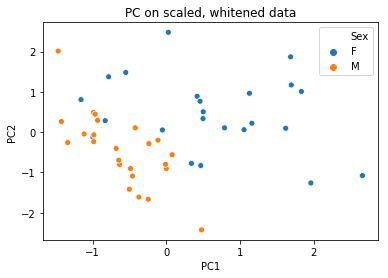

In [8]:
# let's plot something
fig = plt.figure()
ax = sns.scatterplot(data=dfPC, x="PC1", y="PC2", hue="Sex")
ax.set_title("PC on scaled, whitened data")

That's it! We have reduced three dimensions to two. Let's see how much of the original information is in the PC we have found.

### PC analysis stats

In sklearn, stuff with trailing underscore generally refer to stuff that has been computed during the analysis.
Useful info can be retrieved in *PCA.explained_variance_ratio_* and *PCA.components_*

In [9]:
pca.explained_variance_ratio_

array([0.97857922, 0.01428129])

We have that the first PC explains almost all variance, while the second explains about 1.4% of total variance. By construction, PCs are _independent_. Historically, we refer to PC1 as _size_, while to PC2 as _shape_.
In this case, we learn that actually size is what matters more when it comes to defining turtle shells: of course, they **all** are turtle shells, so the maximum of information just tells us how big a turtle shell is.
Other subtle differences (the effect of the environment or the sex on the shape, for instance) will be looked at in PC2.

In [10]:
round(100 - sum(pca.explained_variance_ratio_)*100, 2)

0.71

We have lost 0.71% of total information by reducing our dataset dimensions from three down to 2.

In [11]:
pca.components_

array([[ 0.57879812,  0.57798399,  0.57526276],
       [-0.32502731, -0.48346989,  0.81278171]])

Another useful info is how much each of the original dimensions "weigh" in the definition of each PC.
We see that basically PC1 is evenly affected by each (first row), while PC2 is negatively affected by length and width, and positively by height (second row).
This means that there would be shell shapes that are going to be either shorter in length, narrower but taller, and other ones legthier, broader but shorter in height.

In this case, it is easy to make "real" sense of the data. With more difficult datasets, this might be not be the case, but it also might not be important as long as the new PCs can hel us describe very complicated data.

Mathematically, the squared sum of these components is 1:

In [12]:
for vector in pca.components_:
    print(sum(vector ** 2))

0.9999999999999999
1.0000000000000002


### The effect of data scaling and whitening

I'm going to briefly redo PCA on the original dataset with or without data scaling, and with or whitout whitening, and plot the results to practically see what the different approaches yield.

In [13]:
# === No scaling, no whitening===

pca_noscale_black = PCA(n_components=2, whiten=False)
PC_noscale_black = pca_noscale_black.fit_transform(df.iloc[:, [2,3,4]])
dfPC_noscale_black = pd.DataFrame(PC_noscale_black, columns=["PC1", "PC2"])
dfPC_noscale_black["Sex"] = df["Sex"] # retrieving sex info

# === Scaling, no whitening===
pca_scale_black = PCA(n_components=2, whiten=False)
PC_scale_black = pca_scale_black.fit_transform(x)
dfPC_scale_black = pd.DataFrame(PC_scale_black, columns=["PC1", "PC2"])
dfPC_scale_black["Sex"] = df["Sex"] # retrieving sex info

# === No scaling, whitening===
pca_noscale_white = PCA(n_components=2, whiten=True)
PC_noscale_white = pca_noscale_white.fit_transform(df.iloc[:, [2,3,4]])
dfPC_noscale_white = pd.DataFrame(PC_noscale_white, columns=["PC1", "PC2"])
dfPC_noscale_white["Sex"] = df["Sex"] # retrieving sex info

# === Scaling, whitening===
# already done earlier :)

Text(0.5, 1.0, 'Scaled, whitened')

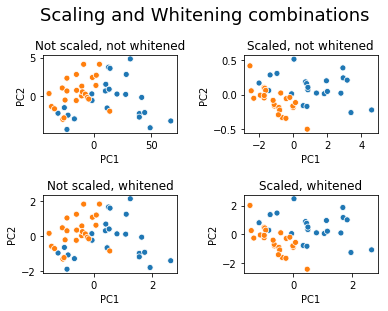

In [14]:
#all happily together
fig = plt.figure()
fig.suptitle("Scaling and Whitening combinations", fontsize=18, y=1.05)
fig.subplots_adjust(hspace=0.8, wspace=0.5)

ax = fig.add_subplot(2,2,1)
ax = sns.scatterplot(data=dfPC_noscale_black, x="PC1", y="PC2", hue="Sex")
ax.legend().set_visible(False)
ax.set_title("Not scaled, not whitened")

ax = fig.add_subplot(2,2,2)
ax = sns.scatterplot(data=dfPC_scale_black, x="PC1", y="PC2", hue="Sex")
ax.legend().set_visible(False)
ax.set_title("Scaled, not whitened")

ax = fig.add_subplot(2,2,3)
ax = sns.scatterplot(data=dfPC_noscale_white, x="PC1", y="PC2", hue="Sex")
ax.legend().set_visible(False)
ax.set_title("Not scaled, whitened")

ax = fig.add_subplot(2,2,4)
ax = sns.scatterplot(data=dfPC, x="PC1", y="PC2", hue="Sex")
ax.legend().set_visible(False)
ax.set_title("Scaled, whitened")

### PC stats with different scaling/whitening combinations

Here are averages and standard deviations of PCs for all four combinations:

In [15]:
analyses = [dfPC_noscale_black, dfPC_scale_black, dfPC_noscale_white, dfPC]
descriptions=[
    "not scaled, not whitened",
    "scaled, not whitened    ",
    "not scaled, whitened    ",
    "scaled, whitened        "
]

for data, descr in zip(analyses, descriptions):
    ave_pc1 = np.average(data["PC1"])
    ave_pc2 = np.average(data["PC2"])
    sd_pc1  = np.std(data["PC1"])
    sd_pc2  = np.std(data["PC2"])
    print(f"{descr} PC1: {abs(round(ave_pc1,1))} ± {round(sd_pc1,1)} {sep}PC2: {abs(round(ave_pc2,1))} ± {round(sd_pc2,1)}")

not scaled, not whitened PC1: 0.0 ± 25.1 	PC2: 0.0 ± 2.3
scaled, not whitened     PC1: 0.0 ± 1.7 	PC2: 0.0 ± 0.2
not scaled, whitened     PC1: 0.0 ± 1.0 	PC2: 0.0 ± 1.0
scaled, whitened         PC1: 0.0 ± 1.0 	PC2: 0.0 ± 1.0


In [16]:
analyses_PC = [pca_noscale_black, pca_scale_black, pca_noscale_white, pca]
for analysis, descr in zip(analyses_PC, descriptions):
    print(f"{descr}: {analysis.explained_variance_ratio_}")

not scaled, not whitened: [0.986113   0.00799921]
scaled, not whitened    : [0.97857922 0.01428129]
not scaled, whitened    : [0.986113   0.00799921]
scaled, whitened        : [0.97857922 0.01428129]


We thus learn that scaling, and not whitening, matters when it comes to computing principal components.
Whitening acts on the numeric features of the PCs, making them with 0 average and 1 standard deviation.

### Take home message

**scaling** data makes the PC analysis more robust, and might be useful to dig out details from PC2+.

**whitening** has no effect on the variance explained by PCs, it affects the numerical properties of PCs, making them with average == 0 and standard_deviation == 1.

### Final remarks

PCA has far more uses than those hinted at in this notebook. For instance, it can even be used to compress and decompress (reconstruct) data such as bitmap images. PCA include complex matrix operations behind the scenes, and words such as eigenvalues, eigenvectors and loadings\*. These are not generally needed in the average molecular biology experiment (my field), and not discussed herein.


\*PCA.components_ are claimed to be vector loadings in most tutorials out there. PCA terminology tends to be rather opaque, because it heavily depends on the field where it is applied.